<p align="center" text-align="center">
  <img width='1000' height='550' src="https://drive.google.com/uc?id=1bKDYbxU8EskcaLuQtoqHZDGSe_nzylUR">
</p>

<p align="center" text-align="center">
  <img width='1000' height='550' src="https://drive.google.com/uc?id=1HlLXJMi1uKNhJ1O1f-OOiN7LNwwsV0CG">
</p>

<p align="center">
  <img width="1000" height="550" src="https://drive.google.com/uc?id=1cS1jGqMJNUAA785VCPjqqUO0rOyxe7Fi">
</p>



# Setting up 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My\ Drive/KagglePUBG

/content/drive/My Drive/KagglePUBG


In [0]:
# import os
# os.environ['KAGGLE_USERNAME'] = "savindi"
# os.environ['KAGGLE_KEY'] = "27711296bda92d3ddad2aaf437f9afdc"

# !kaggle competitions download -c pubg-finish-placement-prediction

In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# import libraries & data

In [0]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns


%matplotlib inline

In [0]:
train=pd.read_csv("train_V2.csv.zip")
train=reduce_mem_usage(train)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


In [0]:
train.head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.5,0,0,0,57,0,0,0,0.0,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137


In [0]:
train.shape

(4446966, 29)

**Four million four hundred forty-six thousand nine hundred sixty-six data points**

# Exploratory Data Analysis

<p align="center" text-align="center">
  <img width='1000' height='550' src="https://drive.google.com/uc?id=12874eEkNJXp9ZPGX7rbdJdxCIbifAfE0">
</p>

In [0]:
print(f"Number of columns :  {len(train.columns)}")
print(train.columns)

Number of columns :  29
Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')


## Utils

In [0]:
def basic_describe(feature):
  """ return basic statistics of the the data"""
  return train[feature].describe().apply(lambda x: format(x,'.2f'))

In [0]:
def draw_percentile_graph(feature,gtype=1):
  percentiles = [25, 50, 75, 90, 95, 97, 99, 100]
  perc_values = np.percentile(train[feature], percentiles)
  sns.set(style="whitegrid")
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 5)
  if gtype:
    ax = sns.lineplot(x=percentiles, y=perc_values)
    ax.set(xlabel='percentiles', ylabel=feature)
  else:
    ax =sns.boxplot(x=train[feature])
    

In [0]:
def draw_hist(col_name, num_bin=10):
    title_name = col_name[0].upper() + col_name[1:]
    f, ax = plt.subplots()
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    ax.set_yscale('log')
    train.hist(column=col_name,ax=ax,bins=num_bin)
    plt.title('Histogram of ' + title_name)
    tmp = train[col_name].value_counts().sort_values(ascending=False)

## GroupID vs MatchID



*   In a particular match, there can be maximum of 100 members
*   There are 3 main modes; **Solo**(Playing as Individual), **Duos**(2 players in the team), **Squad** (4 players maximum in a team)
*   There are other events in games, for example you can play as a zombie. Those are typically not considered as the main stream. Hence, we can drop these in **Feature Engineering Section**.



In [0]:
# Randomly checking group members in a particular group in a particular match
train[train.groupId=='684d5656442f9e'] # This has maximum of four players in a group (Squad Mode)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.0,5,0,0.640137
953779,3dcf4259b62f66,684d5656442f9e,aeb375fc57110c,2,1,300.75,0,0,6,18,0,2,1,78.000000,1777,squad-fpp,26,25,1476,0,5416.000000,0,0.000000,0,0,1847.0,5,0,0.640137
1366988,5406618d55edc0,684d5656442f9e,aeb375fc57110c,0,2,0.00,0,0,2,56,0,0,0,0.000000,1777,squad-fpp,26,25,1480,0,3676.000000,0,0.000000,0,0,1855.0,8,0,0.640137
1613949,fb37a556eb6a3d,684d5656442f9e,aeb375fc57110c,0,3,179.00,2,0,5,17,0,2,2,5.679688,1777,squad-fpp,26,25,1491,0,3694.000000,0,0.000000,0,0,2436.0,6,0,0.640137


In [0]:
# Check member count in  particular group
train['memberCount'] = train.groupby('groupId')['groupId'].transform('count')

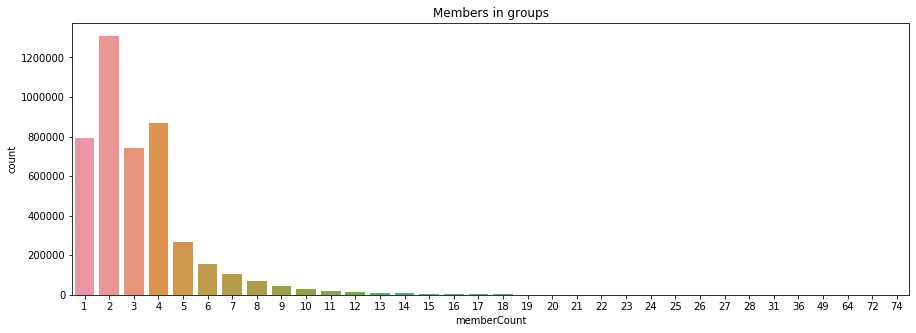

In [0]:
# Plot member count 
plt.figure(figsize=(15,5))
sns.countplot(train['memberCount'])
plt.title('Members in groups')
plt.show()

In [0]:
basic_describe('memberCount')

count    4446966.00
mean           3.21
std            2.26
min            1.00
25%            2.00
50%            3.00
75%            4.00
max           74.00
Name: memberCount, dtype: object

In [0]:
# Check Percentage of Main stream game players 
print("{} players ({:.2f}%) belongs to 4 member group or lesser".format(len(train[train['memberCount']<=4]), 100*len(train[train['memberCount']<=4])/len(train)))

3712270 players (83.48%) belongs to 4 member group or lesser


**We can drop the remaining 16.52% in the Feature Engineering Stage as they does not belong to main stream matches**

In [0]:
# Check number of players in a particular match
len(train[train.matchId=='aeb375fc57110c'] ) # So this perticular macth 91 players

91

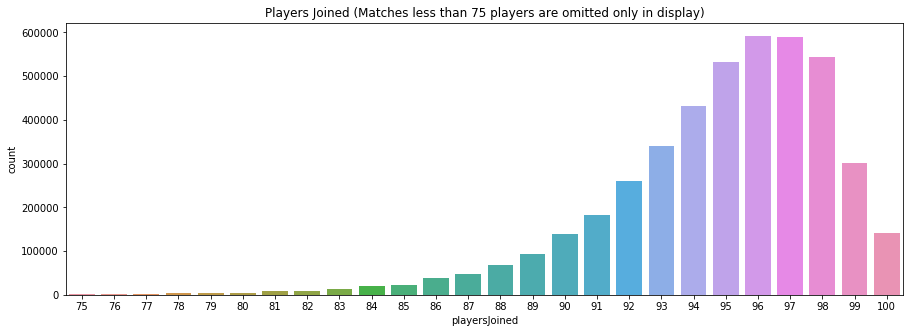

In [0]:
# playersJoined or MatchSize

def calculate_playersJoined():
  train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

calculate_playersJoined()
plt.figure(figsize=(15,5))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('Players Joined (Matches less than 75 players are omitted only in display)')
plt.show()

**We cannot drop any observation depending on MatchSize. However we can use it for normalization of data**

## Variables related to Kills

### Kills

count    4446966.00
mean           0.92
std            1.56
min            0.00
25%            0.00
50%            0.00
75%            1.00
max           72.00
Name: kills, dtype: object


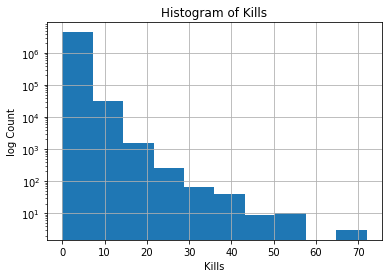

In [0]:
print(basic_describe('kills'))
draw_hist('kills')

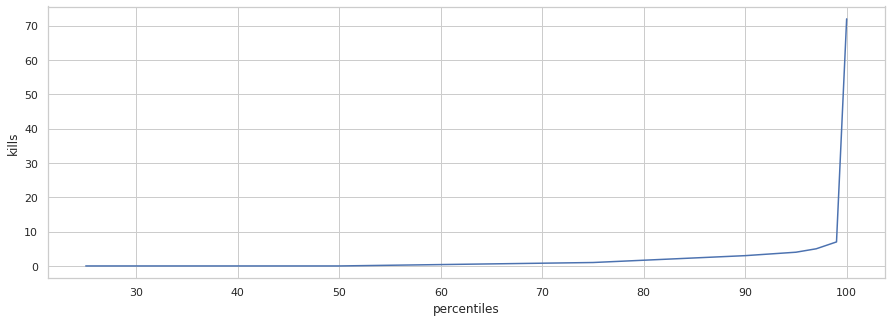

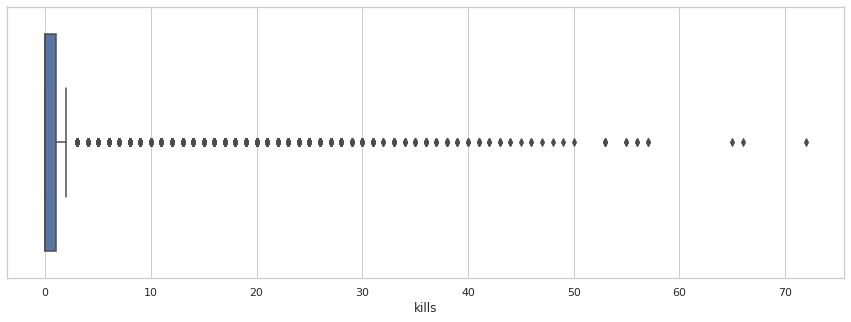

In [0]:
draw_percentile_graph('kills')
draw_percentile_graph('kills',0)

In [0]:
print("99% of players have {} kills or lesser".format(train['kills'].quantile(0.99)))

99% of players have 7.0 kills or lesser


**Lots of outliers**

In [0]:
np.sort(train.kills.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       53, 55, 56, 57, 65, 66, 72])

In [0]:
train.kills.value_counts()

0     2529722
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
26         27
25         27
28         22
27         21
29         13
30         13
31         13
33         12
36          8
35          7
38          7
34          5
37          5
41          5
32          4
39          4
40          4
53          4
43          3
42          3
44          2
46          2
55          2
56          2
57          2
45          1
47          1
48          1
49          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

**We can see there are many outliers in the Kills. Also note that we have high number of train examples. Hence we can truncate the dataset and remove those outliers, after like 30 kills or we can take 99% quatile and truncate at 7 kills max**

We will do that in Feature Extraction Section

13610

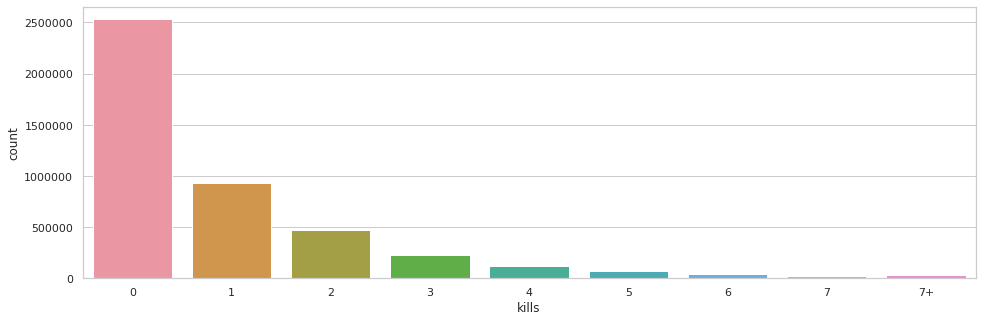

In [0]:
data = train.copy()
sns.set(style="whitegrid")
sns.set_palette("Reds")
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)

data.loc[data['kills'] > data['kills'].quantile(0.99)] = '7+'
sns.countplot(data['kills'].astype('str').sort_values())

del data
gc.collect()

In [0]:
zero_killers = train.copy()
zero_killers = zero_killers[zero_killers['kills']==0]

In [0]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(zero_killers[zero_killers['winPlacePerc']==1]), 100*len(zero_killers[zero_killers['winPlacePerc']==1])/len(train)))

16666 players (0.3748%) have won without a single kill!


### Damage Dealt
DamageDealt indicates the total amount of damage that player makes.

In [0]:
zero_killers['damageDealt'].describe().apply(lambda x: format(x,'.2f'))

count    2529722.00
mean            nan
std             nan
min            0.00
25%            0.00
50%           10.50
75%           68.31
max         2080.00
Name: damageDealt, dtype: object

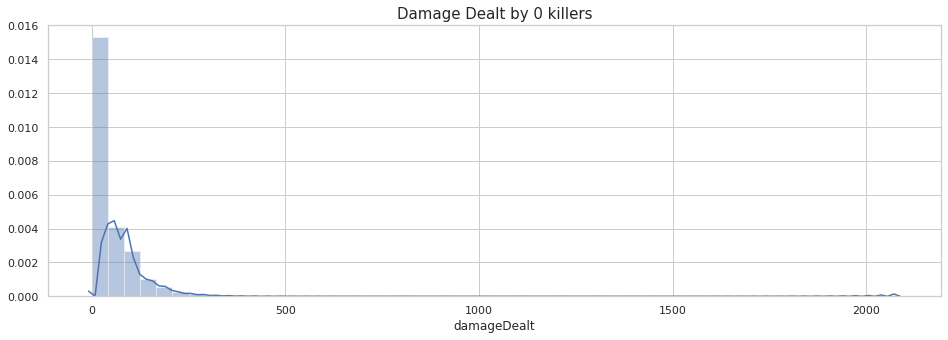

In [0]:
sns.set(style="whitegrid")
sns.dark_palette("blue")
plt.figure(figsize=(16,5))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(zero_killers['damageDealt'])
plt.show()

In [0]:
zero_damage_dealt = train[train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(zero_damage_dealt[zero_damage_dealt['winPlacePerc']==1]), 100*len(zero_damage_dealt[zero_damage_dealt['winPlacePerc']==1])/len(train)))

4770 players (0.1073%) have won without dealing damage!


In [0]:
del zero_killers, zero_damage_dealt
gc.collect()

5869

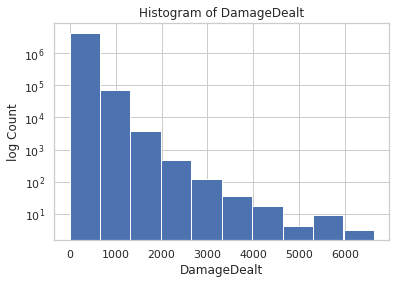

In [0]:
draw_hist('damageDealt')

### Kill streaks
KillStreaks is the count of killing enemies continuously in a small range of time.

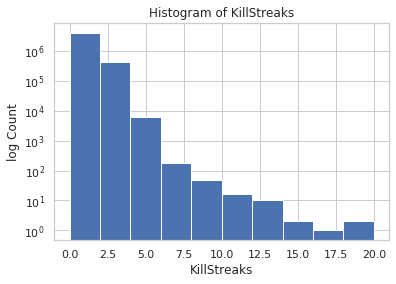

In [0]:
draw_hist('killStreaks')

count    4446966.00
mean           0.54
std            0.71
min            0.00
25%            0.00
50%            0.00
75%            1.00
max           20.00
Name: killStreaks, dtype: object


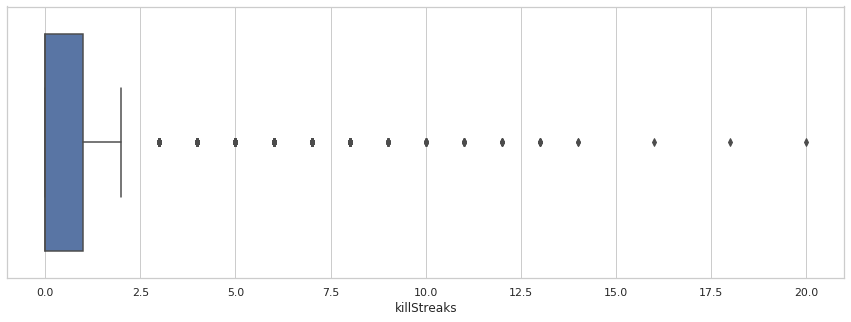

In [0]:
print(basic_describe('killStreaks'))
draw_percentile_graph('killStreaks', 0)

In [0]:
print("Only {} players have killstreak higher than 10".format(train[train['killStreaks'] >10].shape[0]))

Only 23 players have killstreak higher than 10


**In most cases those players can be considered as outliers**

### Road kills
RoadKills is the count of killing enemies when the player is in a vehicle.

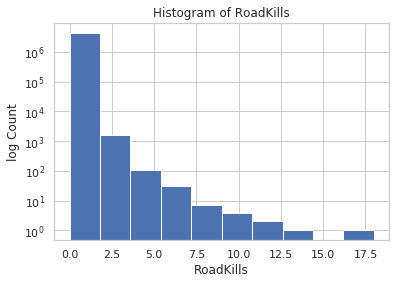

In [0]:
draw_hist('roadKills')

count    4446966.00
mean           0.00
std            0.07
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           18.00
Name: roadKills, dtype: object


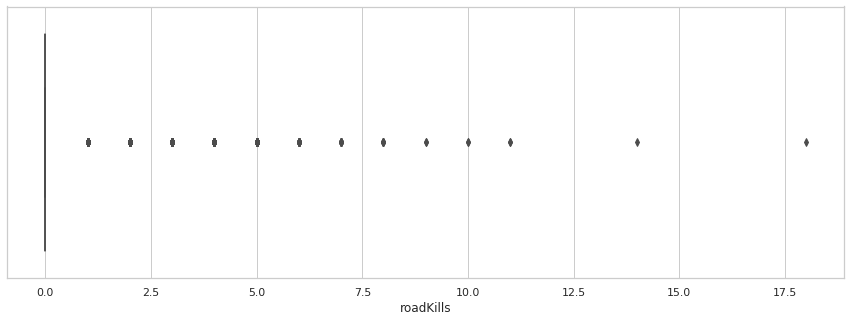

In [0]:
print(basic_describe('roadKills'))
draw_percentile_graph('roadKills', 0)

### Team kills
TeamKills indicates the count of a player killing teammates.

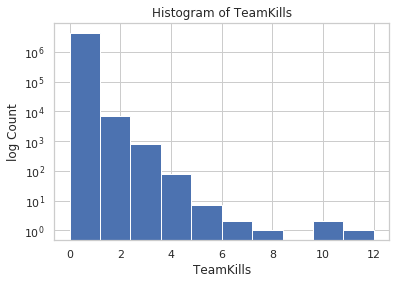

In [0]:
draw_hist('teamKills')

count    4446966.00
mean           0.02
std            0.17
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           12.00
Name: teamKills, dtype: object


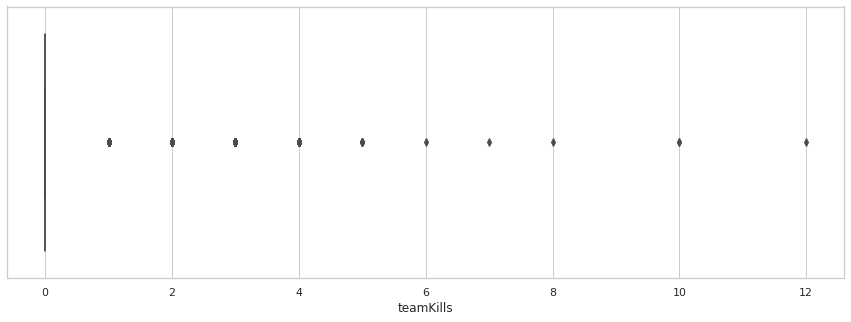

In [0]:
print(basic_describe('teamKills'))
draw_percentile_graph('teamKills', 0)

In [0]:
print("{} players have more than 3 team kills. but only 3 members(max) are in a team except for the player unless they reived can't have more than 3. Therefore these are abnormal".format(train[train['teamKills'] > 3].shape[0]))

94 players have more than 3 team kills. but only 3 members(max) are in a team except for the player unless they reived can't have more than 3. Therefore these are abnormal


### Longest kills
LongestKill is the longest distance for the distance between a player and the enemy killed by him.

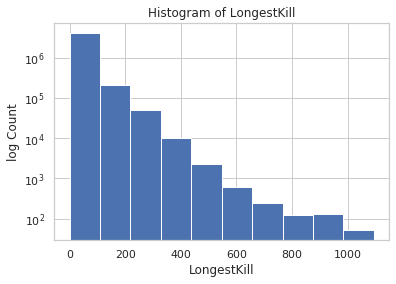

In [0]:
draw_hist('longestKill')

count    4446966.00
mean            nan
std             nan
min            0.00
25%            0.00
50%            0.00
75%           21.31
max         1094.00
Name: longestKill, dtype: object


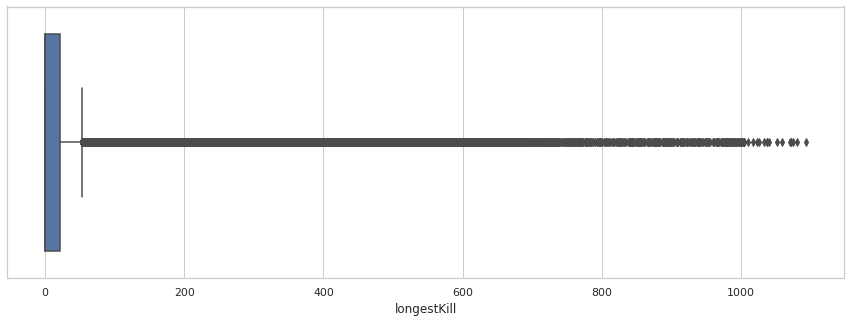

In [0]:
print(basic_describe('longestKill'))
draw_percentile_graph('longestKill', 0)

In [0]:
print("Only {} players made kills with a distance of more than 1 km".format(train[train['longestKill'] >= 1000].shape[0]))

Only 24 players made kills with a distance of more than 1 km


**Those players can be considered as outliers. We will remove them in Feature Engineering**

### Headshots
If a player kill enemies by shooting their head, these kills will be counted as HeadShot Kills, which will make more damage than shooting other part of enemy's body.

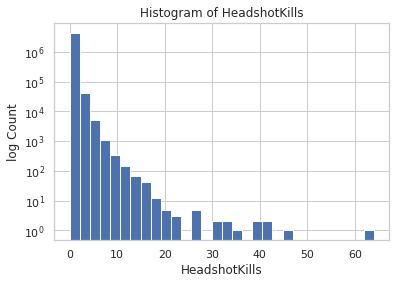

In [0]:
draw_hist('headshotKills',num_bin=30)

count    4446966.00
mean           0.23
std            0.60
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           64.00
Name: headshotKills, dtype: object


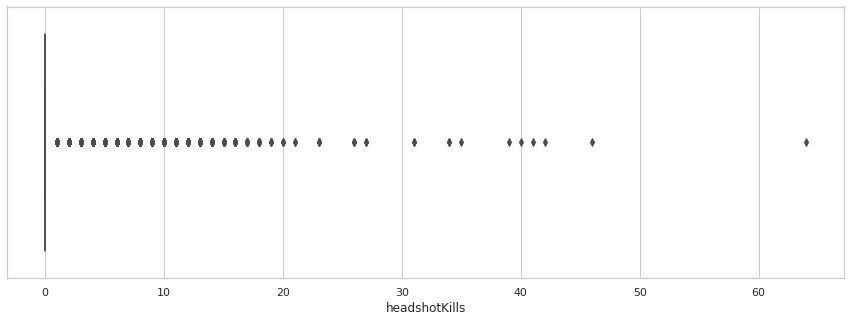

In [0]:
print(basic_describe('headshotKills'))
draw_percentile_graph('headshotKills', 0)

# High number headshot will be a cheater or hack/bot

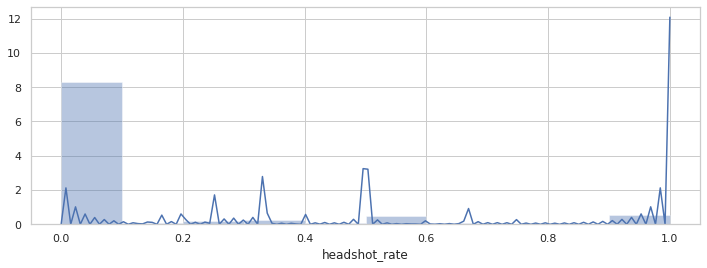

Only 13 players (0.0003%) have 100% headshot rate with more than 10 kills


In [0]:
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

df = train[(train['headshot_rate'] == 1) & (train['kills'] > 10)]
print("Only {} players ({:.4f}%) have 100% headshot rate with more than 10 kills".format(df.shape[0], df.shape[0]/train.shape[0]*100))

In [0]:
del df
gc.collect()

42042

**These 13 players who have 100% headshot rate with more than 10 kills most probably will be bots or cheaters. Hence will be removed in feature engineering**

### DBNOs
DBNO indeicates the number of enemies that the player knocks down. Knocking down enemies means making damage to them and their health points go down to zero. After that, the enemies can only crawl and will not be able to fight anymore except that their teammates cure them (That is known as **Revive**). If the player continue making damage to the knocked enemies and make their health points zero again, the enemies will be killed and eliminated.

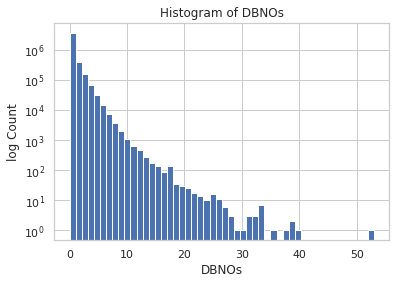

In [0]:
draw_hist('DBNOs',num_bin=50)

count    4446966.00
mean           0.66
std            1.15
min            0.00
25%            0.00
50%            0.00
75%            1.00
max           53.00
Name: DBNOs, dtype: object


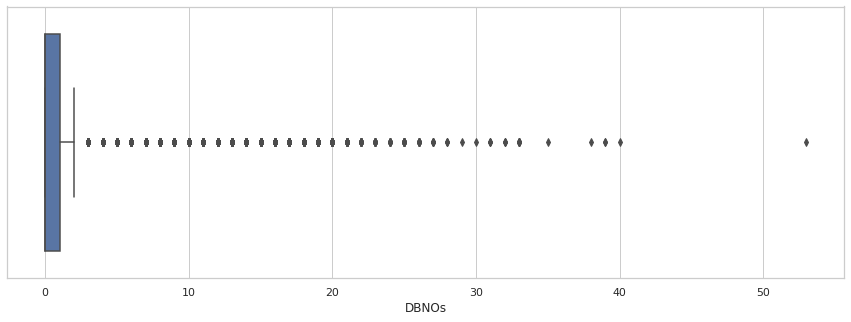

In [0]:
print(basic_describe('DBNOs'))
draw_percentile_graph('DBNOs',0)

In [0]:
print("Only {} players made more than 20 enemy-knockouts during a match".format(train[train['DBNOs'] >= 20].shape[0]))

Only 155 players made more than 20 enemy-knockouts during a match


### Assits
Assists in the match means that the player contributes damage to the killed enemy but he/she is not the player that make the last attack to kill that enemy. Once the contribution is made and the enemy is killed by other player, the count of assists will plus one.

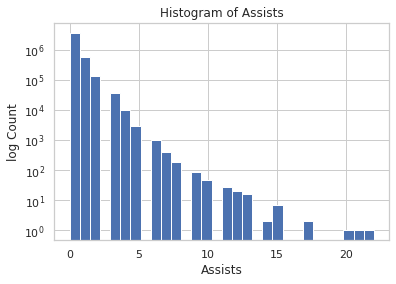

In [0]:
draw_hist('assists',num_bin=30)

count    4446966.00
mean           0.23
std            0.59
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           22.00
Name: assists, dtype: object


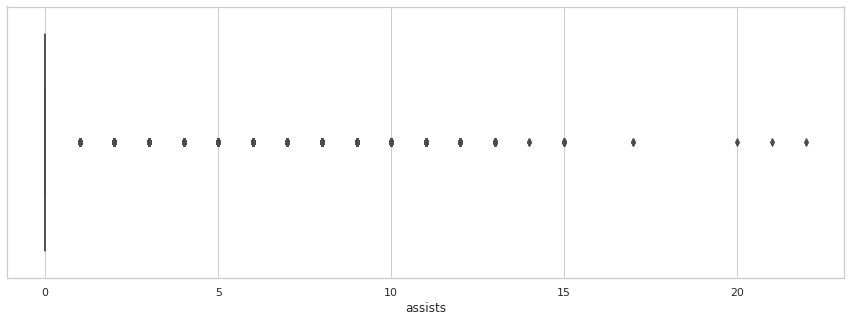

In [0]:
print(basic_describe('assists'))
draw_percentile_graph('assists', 0)

In [0]:
print("Only {} players made more than 10 assists to a team member to kill an enemy during a match".format(train[train['assists'] >= 10].shape[0]))

Only 125 players made more than 10 assists to a team member to kill an enemy during a match


## Variables related to Distances
There are three types of distance value in the given dataset. 
* **WalkDistance** is the total travelling distance on foot measured in meters. 
* **RideDistance** is the total travelling distance on vehicles measured in meters. 
* **SwimDistance** is the total travelling distance by swimming measured in meters.

In [0]:
def distance_distribution_q99(distancetype):
  data = train.copy()
  data = data[data[distancetype] < train[distancetype].quantile(0.99)]
  plt.figure(figsize=(10,5))
  plt.title(distancetype+" Distribution",fontsize=15)
  sns.distplot(data[distancetype])
  plt.show()
  del data
  gc.collect()
  print("")
  print("99% of players have {} meters {} or lesser".format(train[distancetype].quantile(0.99), distancetype))
  print("Only {} players accounts to the remaining 1%".format(train[train[distancetype] > train[distancetype].quantile(0.99)].shape[0]))

##### Walk distance

count    4446966.00
mean            nan
std             nan
min            0.00
25%          155.12
50%          685.50
75%         1976.00
max        25776.00
Name: walkDistance, dtype: object


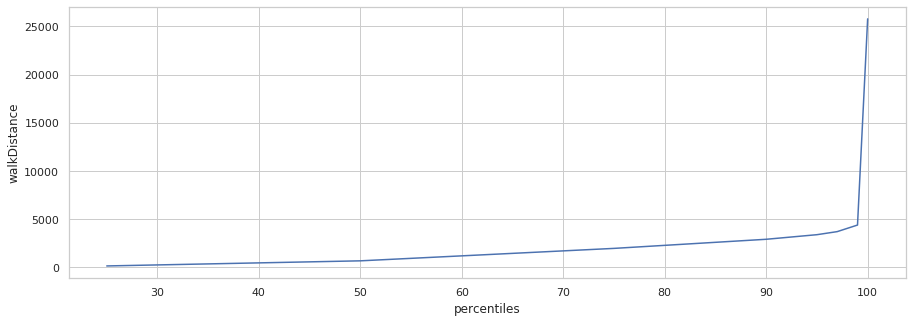

In [0]:
print(basic_describe('walkDistance'))
draw_percentile_graph('walkDistance')

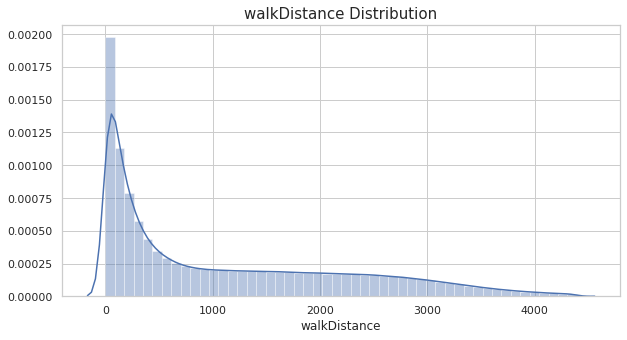


99% of players have 4396.0 meters walkDistance or lesser
Only 44400 players accounts to the remaining 1%


In [0]:
distance_distribution_q99('walkDistance')

**We will not remove all 1%. But in Feature Engineering we will remove most of them** 

### Ride distance

count    4446966.00
mean            nan
std             nan
min            0.00
25%            0.00
50%            0.00
75%            0.19
max        40704.00
Name: rideDistance, dtype: object


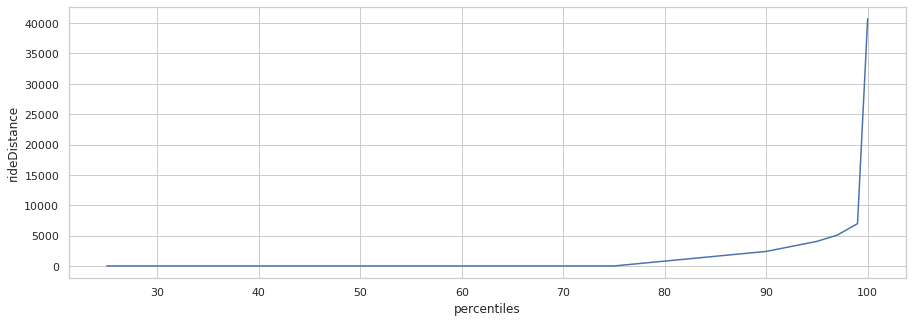

In [0]:
print(basic_describe('rideDistance'))
draw_percentile_graph('rideDistance')

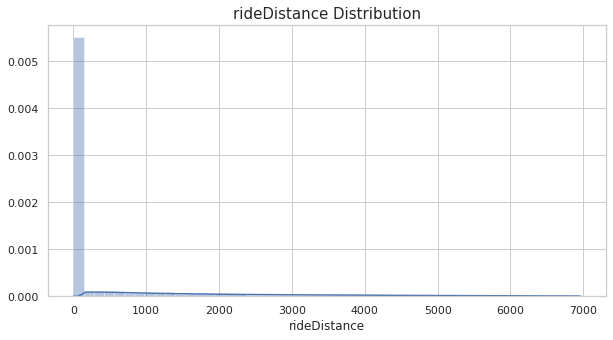


99% of players have 6968.0 meters rideDistance or lesser
Only 44337 players accounts to the remaining 1%


In [0]:
distance_distribution_q99('rideDistance')

**We will not remove all 1%. But in Feature Engineering we will remove most of them** 

### Swim distance

count    4446966.00
mean            nan
std             nan
min            0.00
25%            0.00
50%            0.00
75%            0.00
max         3824.00
Name: swimDistance, dtype: object


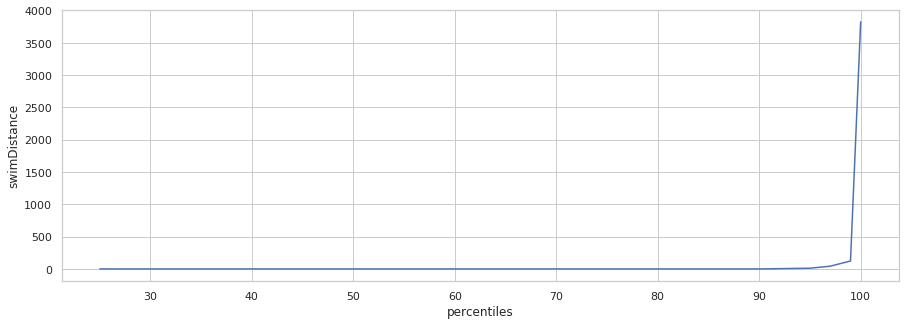

In [0]:
print(basic_describe('swimDistance'))
draw_percentile_graph('swimDistance')

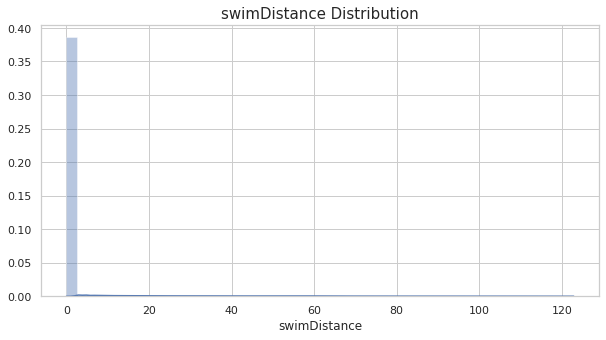


99% of players have 123.0 meters swimDistance or lesser
Only 44421 players accounts to the remaining 1%


In [0]:
distance_distribution_q99('swimDistance')

In [0]:
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

In [0]:
print("{} players ({:.2f}%) died before moving at all (or they were AFK & got killed)".format(train[train['totalDistance']==0].shape[0], train[train['walkDistance']==0].shape[0]/train.shape[0]*100))

97370 players (2.24%) died before moving at all (or they were AFK & got killed)


## Variables related to health
* **Boost** indicates the number of times of using boosting items such as energy drink, which will help increase the moving speed and recover the health point slowly. 
* **Heals** indicates using healing items such as medical bandage, which will recover the health point instantly after waiting for casting time for several seconds.


### boost

count    4446966.00
mean           1.11
std            1.72
min            0.00
25%            0.00
50%            0.00
75%            2.00
max           33.00
Name: boosts, dtype: object


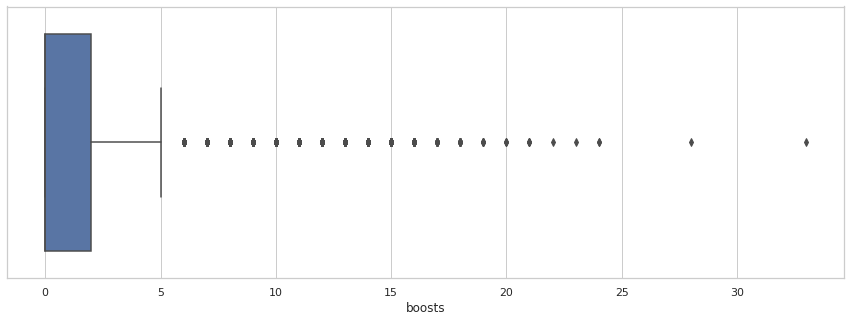

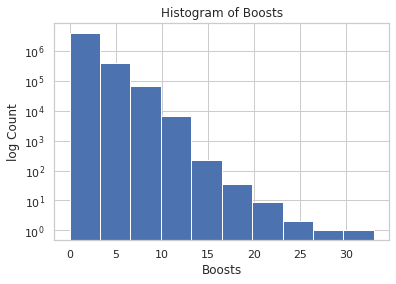

In [0]:
print(basic_describe('boosts'))
draw_percentile_graph('boosts', 0)
draw_hist('boosts')

### health

count    4446966.00
mean           1.37
std            2.68
min            0.00
25%            0.00
50%            0.00
75%            2.00
max           80.00
Name: heals, dtype: object


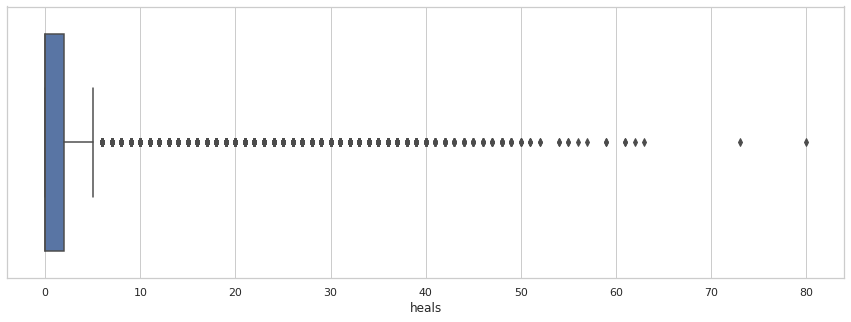

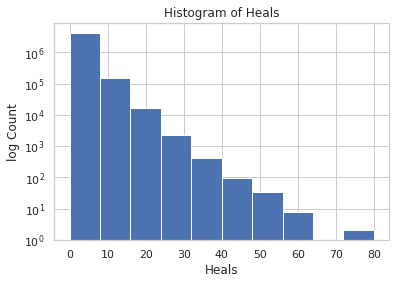

In [0]:
print(basic_describe('heals'))
draw_percentile_graph('heals', 0)
draw_hist('heals')

**Both Heals and Boosts are pretty much similar. So we can use feature aggregation on these 2 features**

## Variables related to External Elo Rankings

The **Elo rating system** is a method for calculating the relative skill levels of players in zero-sum (All losses and gains by participants sum upto zero. i.e. one players loss is a gain to another) games. Various online games use Elo ratings for player-versus-player rankings. 

###  Kill Place
Ranking in match depending on number of enemy players killed. Lowest value have higher win.

count    4446966.00
mean          47.60
std           27.46
min            1.00
25%           24.00
50%           47.00
75%           71.00
max          101.00
Name: killPlace, dtype: object


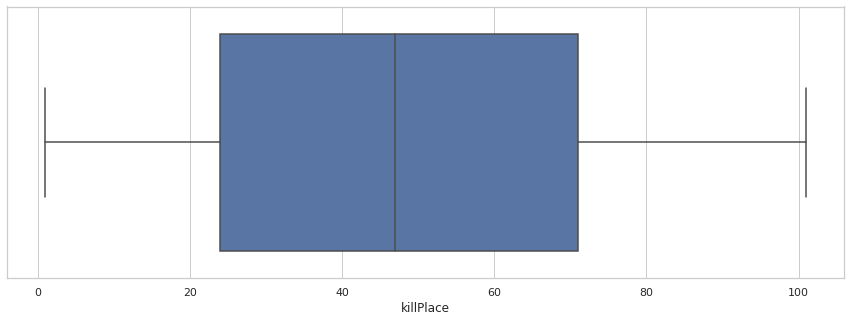

In [0]:
print(basic_describe('killPlace'))
draw_percentile_graph('killPlace', 0)

### Kill points
Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”. We will handle these in Feature Engineering

count    4446966.00
mean         505.01
std          627.50
min            0.00
25%            0.00
50%            0.00
75%         1172.00
max         2170.00
Name: killPoints, dtype: object


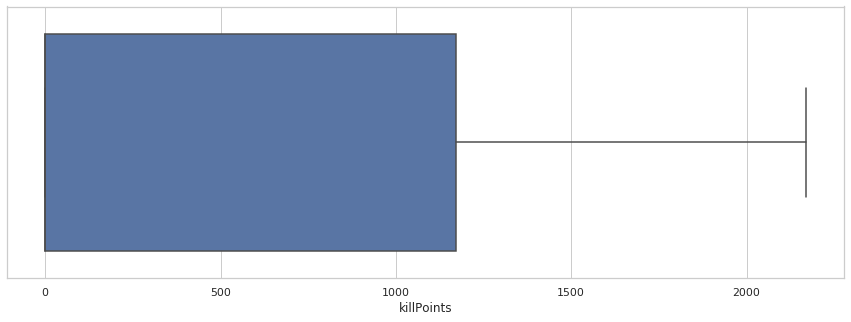

In [0]:
print(basic_describe('killPoints'))
draw_percentile_graph('killPoints', 0)

### Rank Points
Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”. We will handle these in Feature Engineering

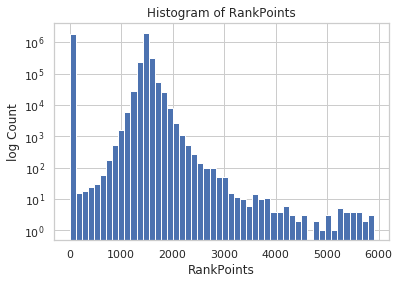

In [0]:
draw_hist('rankPoints',num_bin=50)

count    4446966.00
mean         892.01
std          736.65
min           -1.00
25%           -1.00
50%         1443.00
75%         1500.00
max         5910.00
Name: rankPoints, dtype: object


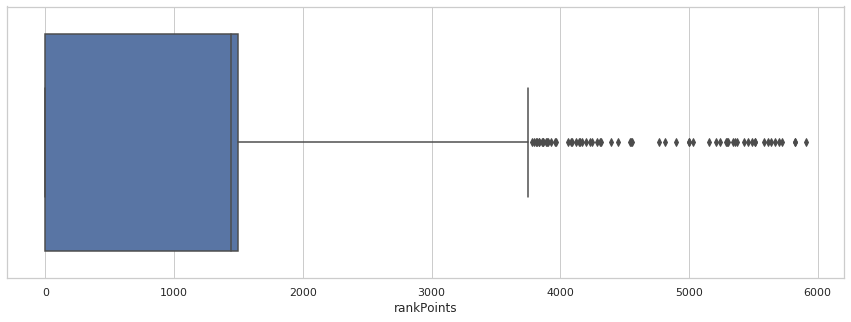

In [0]:
print(basic_describe('rankPoints'))
draw_percentile_graph('rankPoints', 0)

### Win Points
Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”. We will handle these in Feature Engineering

count    4446966.00
mean         606.46
std          739.70
min            0.00
25%            0.00
50%            0.00
75%         1495.00
max         2013.00
Name: winPoints, dtype: object


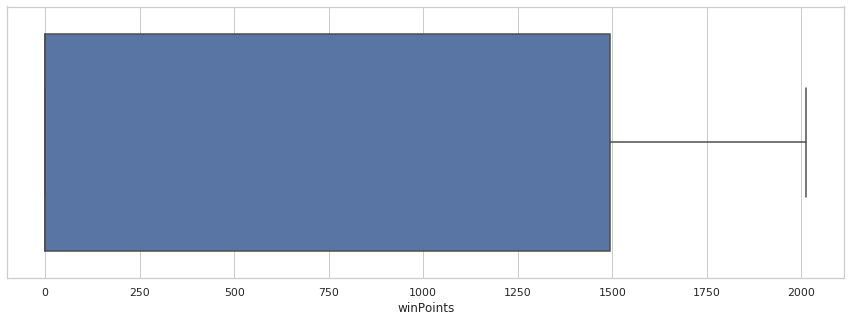

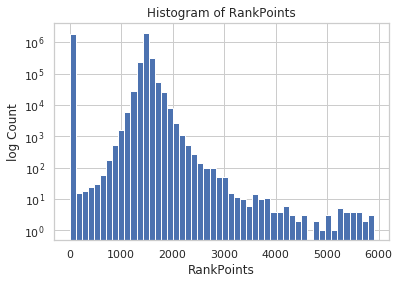

In [0]:
print(basic_describe('winPoints'))
draw_percentile_graph('winPoints', 0)
draw_hist('rankPoints',num_bin=50)

##  Other Variables

### Weapons Acquired
There are many types of weapons exist in this game. Players need to search them and then they can use them for battle. Weapons Acquired indicates the number of weapons each player acquired per match.

In [0]:
basic_describe('weaponsAcquired')

count    4446966.00
mean           3.66
std            2.46
min            0.00
25%            2.00
50%            3.00
75%            5.00
max          236.00
Name: weaponsAcquired, dtype: object

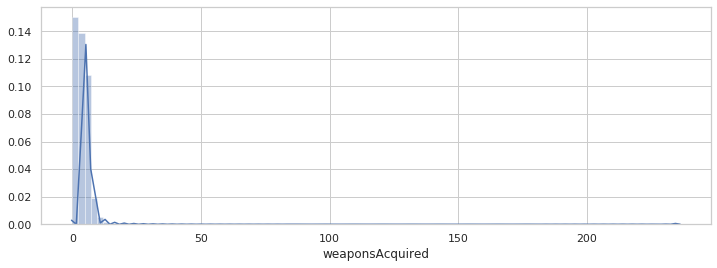

In [0]:
# Plot the distribution of weaponsAcquired
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [0]:
# Players who acquired more than 80 weapons
print("Only {} players aquired more than 80 weapons during a match".format(train[train['weaponsAcquired'] >= 80].shape[0]))

Only 21 players aquired more than 80 weapons during a match


### Vehicles Destroyed
VehicleDestroys Analysis is the number of vehicles that players destroy

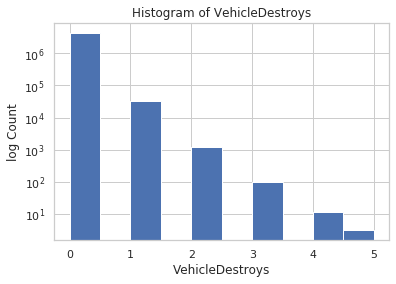

In [0]:
draw_hist(('vehicleDestroys'))

count    4446966.00
mean           0.01
std            0.09
min            0.00
25%            0.00
50%            0.00
75%            0.00
max            5.00
Name: vehicleDestroys, dtype: object


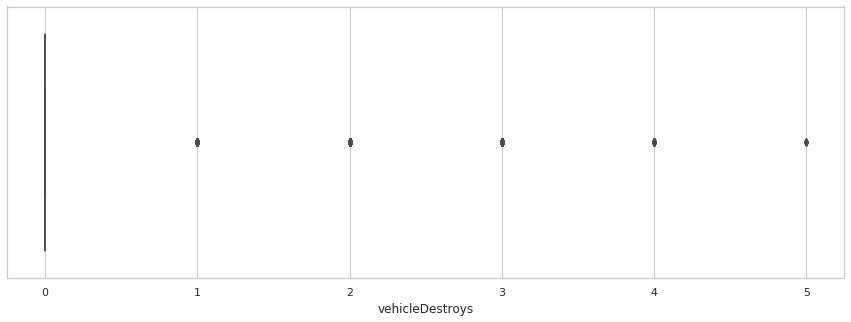

In [0]:
print(basic_describe('vehicleDestroys'))
draw_percentile_graph('vehicleDestroys', 0)

In [0]:
# Players who destroyed more than 2 vehicles in a match
print("Only {} players ({:.4f}%) destroyed more than 2 vehicles during a match".format(train[train['vehicleDestroys'] > 2].shape[0],train[train['vehicleDestroys'] > 2].shape[0]/train.shape[0]*100))

Only 109 players (0.0025%) destroyed more than 2 vehicles during a match


### Revives
Revives means the number of reviving teammates. If a teammate is knockced down but not killed, player can revive that teammate and the count of reviving will be added one.

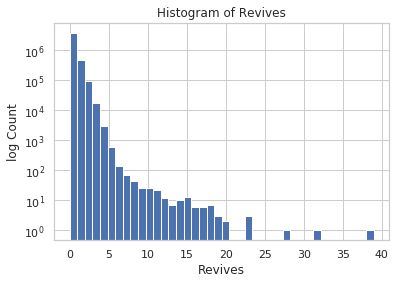

In [0]:
draw_hist('revives',num_bin=40)

count    4446966.00
mean           0.16
std            0.47
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           39.00
Name: revives, dtype: object


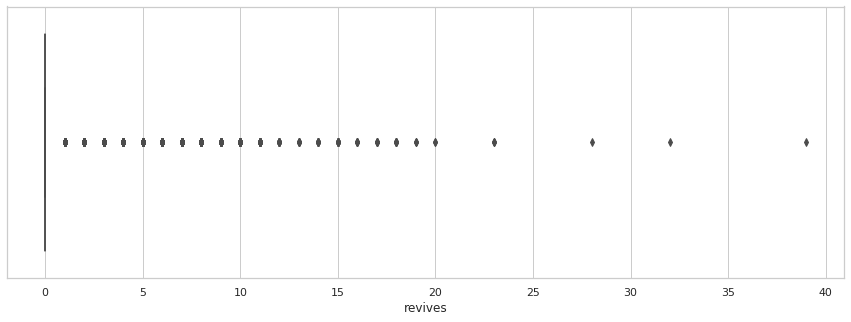

In [0]:
print(basic_describe('revives'))
draw_percentile_graph('revives', 0)

In [0]:
# Players who revived team members more than 5 times in a match
print("Only {} players ({:.4f}%) revived team members more than 5 times during a match".format(train[train['revives'] > 5].shape[0],train[train['revives'] > 5].shape[0]/train.shape[0]*100))

Only 403 players (0.0091%) revived team members more than 5 times during a match


### Solo VS Duos vs Squads

In [0]:
# Categories all to main 3 game modes
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]

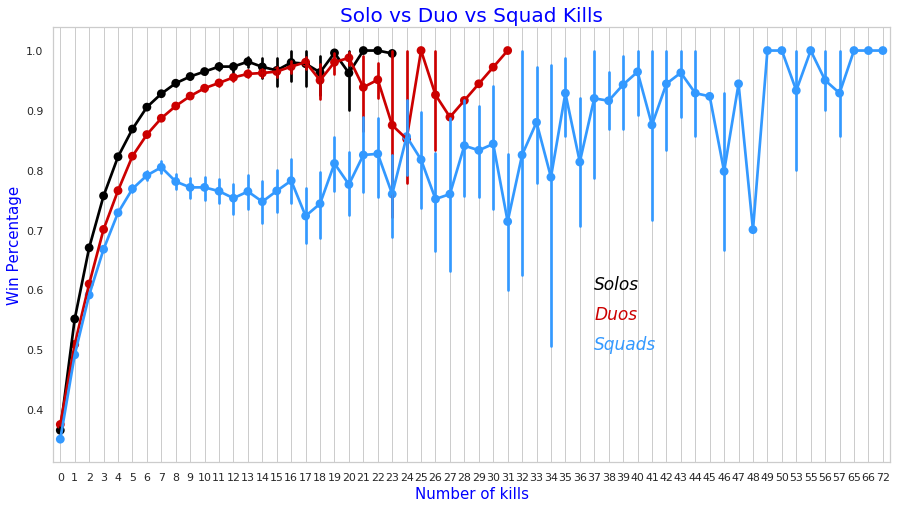

In [0]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()